In [21]:
import torch
import utils
import dlc_practical_prologue as prologue
import time

from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
from itertools import product

In [3]:
def load_data():
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)
    return Variable(train_input), Variable(train_target), Variable(train_classes), Variable(test_input), Variable(test_target), Variable(test_classes)
    
train_input, train_target, train_classes, test_input, test_target, test_classes = load_data()

In [11]:
def count_parameters(model):
    nb_params = 0
    for parameter in model.parameters():
        nb_params = nb_params + parameter.numel()
    return nb_params

In [26]:
def accuracy(model, X, Y, mini_batch_size=100):
    
    nb_errors = 0
    
    # Proceed in batches
    for b in range(0, X.size(0), mini_batch_size):
        
        # Predict batch
        output = model(X.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        
        # Count errors in batch
        for k in range(mini_batch_size):
            if Y[b + k] != predicted_classes[k]:
                nb_errors = nb_errors + 1
    
    accuracy = 1 - nb_errors/X.shape[0]
    return accuracy


def train_model(model, X=train_input, Y=train_target, tX=test_input, tY=test_target,
                mini_batch_size=100, eta=1e-3, epochs=25,
                criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    
    start_time = time.perf_counter()
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    optimizer = opt(model.parameters(), lr=eta)
    
    for e in range(epochs):
        sum_loss = 0
        
        with torch.no_grad():
            # Compute validation loss and accuracy
            val_acc = accuracy(model, tX, tY)
            history['val_acc'].append(val_acc)

            # Compute training accuracy w/o messing with training
            train_acc = accuracy(model, X, Y)
            history['train_acc'].append(train_acc)
            
            # Compute validation loss
            val_output = model(tX)
            val_loss = criterion(val_output, tY)
            history['val_loss'].append(val_loss.item())
            
        for b in range(0, X.size(0), mini_batch_size):
            # Classify batch, compute loss and perform backpropagation with parameter updates
            output = model(X.narrow(0, b, mini_batch_size))
            loss = criterion(output, Y.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss.item()
           
        history['train_loss'].append(sum_loss)
        clear_output(wait=True)
        print('Epoch ' + str(e+1) + '/' + str(epochs))
    
    df_result = pd.DataFrame(history)
    df_result['epoch'] = range(df_result.shape[0])
    end_time = time.perf_counter()
                               
    return df_result, end_time-start_time


def cv_k_loads(model, cv=5, 
              mini_batch_size=100, eta=1e-3, epochs=25,
              criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    
    df_hist = pd.DataFrame(columns=['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch'])
    
    times = []
    for i in range(cv):
        X, Y, Z, tX, tY, tZ = load_data()
        m = model()
        fold_hist, train_time = train_model(m, X, Y, tX, tY, 
                                mini_batch_size=mini_batch_size, eta=eta, epochs=epochs,
                                criterion=criterion, opt=opt)
        
        times.append(train_time)
        df_fold = pd.DataFrame(fold_hist)
        df_fold['epoch'] = range(df_fold.shape[0])
        df_fold['load'] = [i for e in range(df_fold.shape[0])]
        df_hist = pd.concat([df_hist, df_fold])
        
    return df_hist, times


def cv_k_fold(model, X=train_input, Y=train_target, tX=test_input, tY=test_input, cv=5, 
              mini_batch_size=100, eta=1e-3, epochs=25,
              criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    
    split_X = X.chunk(cv)
    split_Y = Y.chunk(cv)
    
    df_hist = pd.DataFrame(columns=['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch'])
    
    times = []
    for i in range(cv):
        m = model()
        rest_X = torch.cat([f for j, f in enumerate(split_X) if j!=i])
        rest_Y = torch.cat([f for j, f in enumerate(split_Y) if j!=i])
        fold_hist, train_time = train_model(m, split_X[i], split_Y[i], rest_X, rest_Y, 
                                mini_batch_size=mini_batch_size, eta=eta, epochs=epochs,
                                criterion=criterion, opt=opt)
        
        times.append(train_time)
        df_fold = pd.DataFrame(fold_hist)
        df_fold['epoch'] = range(df_fold.shape[0])
        df_fold['fold'] = [i for e in range(df_fold.shape[0])]
        df_hist = pd.concat([df_hist, df_fold])
        
    return df_hist, times


def end_of_hist_result(df_hist):
    df_avg = df_hist.groupby('epoch').mean()
    
    # Last epoch result
    last_dict = df_avg.loc[df_avg.index.max()][['train_loss', 'train_acc', 'val_loss', 'val_acc']].to_dict()
    last_dict['epoch'] = df_avg.index.max()
    
    # Best validation accuracy result
    df_avg = df_hist.groupby('epoch').mean()
    best_dict = df_avg.loc[df_avg.val_acc.idxmax()][['train_loss', 'train_acc', 'val_loss', 'val_acc']].to_dict()
    best_dict['epoch'] = df_avg.val_acc.idxmax()
    
    return pd.concat([pd.DataFrame(last_dict, index=['last']), pd.DataFrame(best_dict, index=['best'])])


def grid_search(eval_funct, params):
    param_tuples = list(product(*params.values()))
    
    df_grid_search = pd.DataFrame(columns=['mean_train_loss', 'mean_train_acc', 'mean_val_loss', 'mean_val_acc'])
    for p in param_tuples:
        df_params = eval_funct(p)
        res = end_of_hist_result(df_params).loc['last']
        df_grid_search.loc[str(p)] = [res['train_loss'], res['train_acc'], res['val_loss'], res['val_acc']]
        
    df_grid_search['rank_val_acc'] = df_grid_search.rank(method='first')['mean_val_acc'].astype(int)
    return df_grid_search
        

def plot_hist(df_history, savefig=None):

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # Loss subplot
    ax1.set_title('Evolution of cross-entropy loss over training')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.yaxis.grid(True)
    sns.lineplot(x='epoch', y='train_loss', data=df_history, label='training', ax=ax1)
    sns.lineplot(x='epoch', y='val_loss', data=df_history, label='validation', ax=ax1)
    
    # Accuracy subplot
    ax2.set_title('Evolution of classification accuracy over training')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.yaxis.grid(True)
    sns.lineplot(x='epoch', y='train_acc', data=df_history, label='training', ax=ax2)
    sns.lineplot(x='epoch', y='val_acc', data=df_history, label='validation', ax=ax2)
    
    display(end_of_hist_result(df_history))

    if savefig != None:
        plt.savefig('./results/' + savefig + '.jpg')
    plt.show()

In [54]:
class ConvNet1(nn.Module):
    def __init__(self, nb_hidden=100):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 256))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
conv_net_1 = ConvNet1()
print(count_parameters(conv_net_1))

45006


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.019256,1.0,0.939307,0.7946,49
best,0.023340,1.0,0.913161,0.7960,47


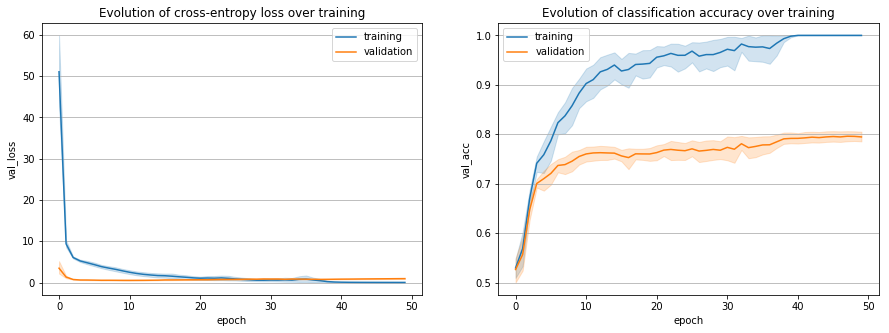

In [31]:
# Example of multi-load training, using folds as validation and averaging over them
loads_model = ConvNet1
loads_hist, times = cv_k_loads(cv_model, epochs=50, cv=10)
plot_hist(loads_hist)

In [47]:
class CN3(nn.Module):
    def __init__(self, nb_hidden=100):
        super(CN3, self).__init__()
        self.conv1 = nn.Conv2d(2, 35, kernel_size=3)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(35, 70, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(70, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 70))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
CN_3 = CN3()
print(count_parameters(CN_3))

69287


Epoch 75/75


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.790215,0.9739,0.796294,0.8038,74
best,0.908958,0.9760,0.746368,0.8079,69


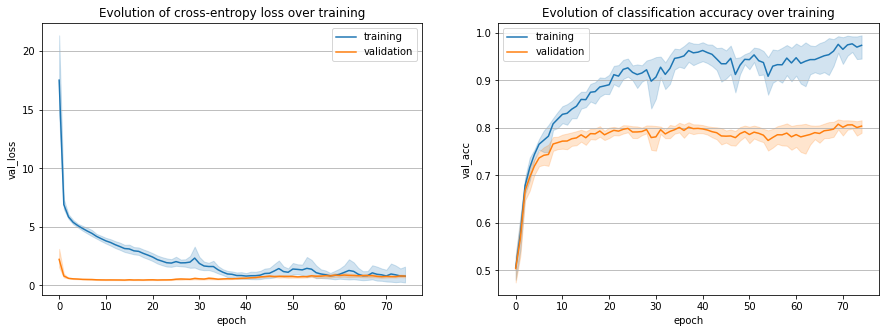

In [55]:
m = CN3
h, t = cv_k_loads(m, epochs=75, cv=10)
plot_hist(h)

Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.835927,0.9670,0.763046,0.7976,49
best,1.491673,0.9616,0.578102,0.8080,36


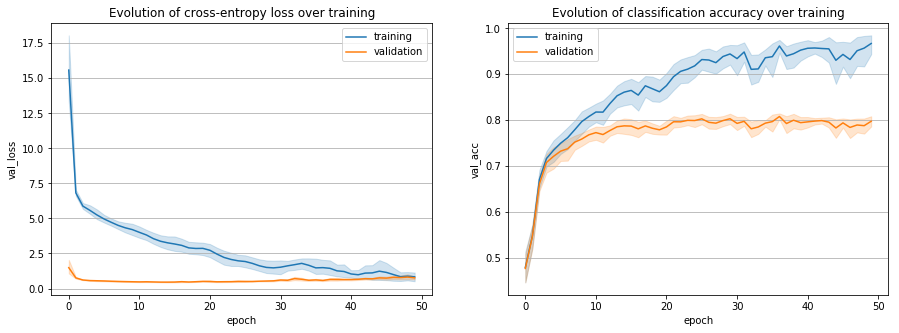

In [48]:
m = CN3
h, t = cv_k_loads(m, epochs=50, cv=10)
plot_hist(h)

In [52]:
class CN4(nn.Module):
    def __init__(self, nb_hidden=100):
        super(CN4, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 256))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
CN_4 = CN4()
print(count_parameters(CN_4))

57534


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.001334,1.0,1.247628,0.7889,49
best,0.001539,1.0,1.229539,0.7891,46


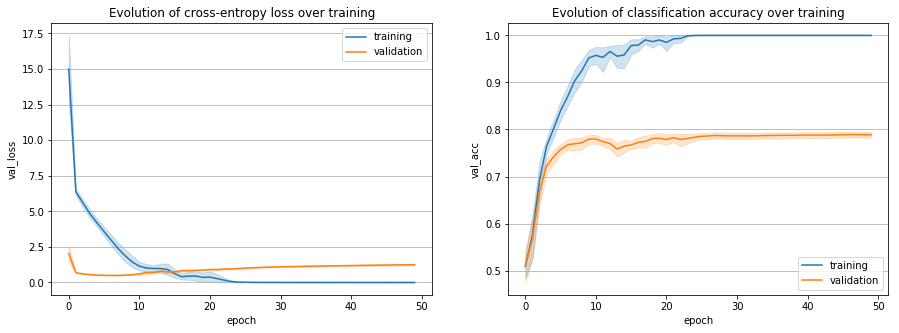

In [53]:
m = CN4
h, t = cv_k_loads(m, epochs=50, cv=10)
plot_hist(h)

In [63]:
class CN5(nn.Module):
    def __init__(self, nb_hidden=100):
        super(CN5, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(10, 25, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(25, 25, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(25, 25, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(25, 50, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(50, 50, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(50, 50, kernel_size=3)
        self.fc1 = nn.Linear(50, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv8(x)
        x = F.relu(x)
        x = self.conv9(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 50))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
CN_5 = CN5()
print(count_parameters(CN_5))

77287


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.000272,1.0000,1.975224,0.7771,49
best,0.014667,0.9997,1.855277,0.7777,44


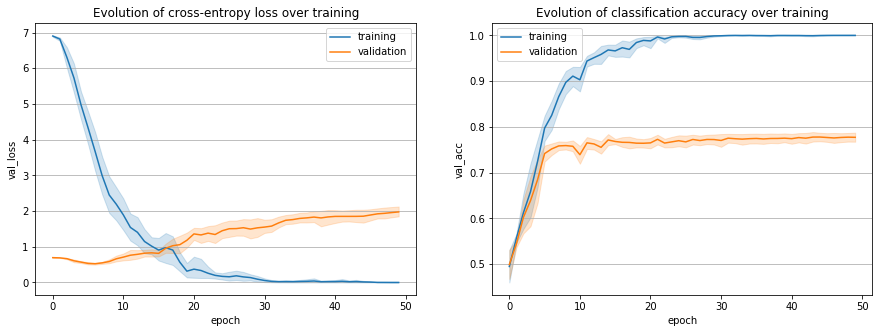

In [64]:
m = CN5
h, t = cv_k_loads(m, epochs=50, cv=10)
plot_hist(h)

In [82]:
class CN6(nn.Module):
    def __init__(self, nb_hidden=128):
        super(CN6, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4) 
        self.fc1 = nn.Linear(64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 64))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
CN_6 = CN6()
print(count_parameters(CN_6))

67106


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.002491,1.0,0.905588,0.8143,49
best,0.004358,1.0,0.843230,0.8151,43


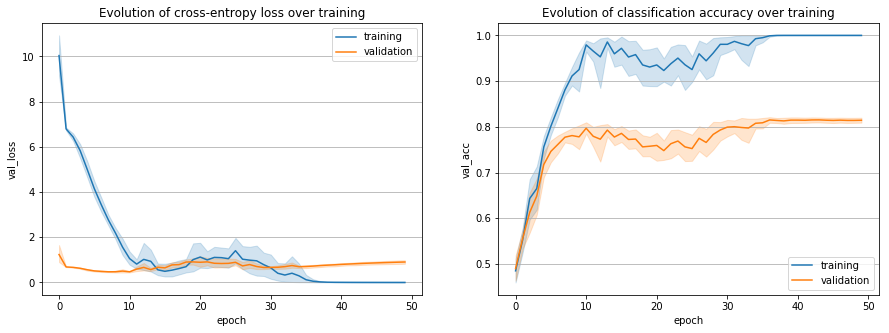

In [83]:
m = CN6
h, t = cv_k_loads(m, epochs=50, cv=10)
plot_hist(h)

In [91]:
class CN7(nn.Module):
    def __init__(self, nb_hidden=50):
        super(CN7, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 256))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
CN_7 = CN7()
print(count_parameters(CN_7))

71480


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.001635,1.0,0.980303,0.8124,49
best,0.005730,1.0,0.849237,0.8130,31


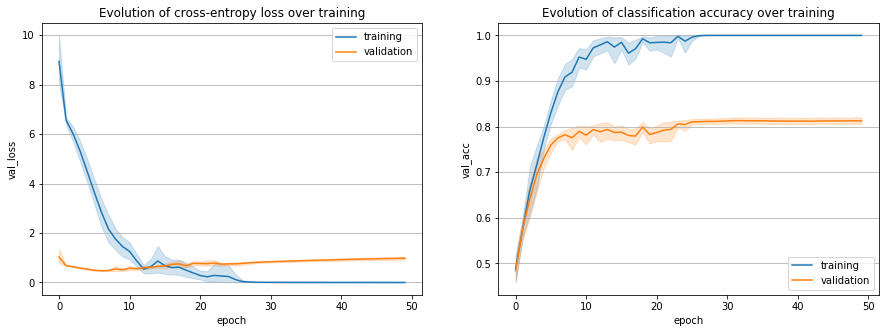

In [92]:
m = CN7
h, t = cv_k_loads(m, epochs=50, cv=10)
plot_hist(h)

In [94]:
class CN8(nn.Module):
    def __init__(self, nb_hidden=128):
        super(CN8, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4) 
        self.fc1 = nn.Linear(64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 64))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
CN_8 = CN8()
print(count_parameters(CN_8))

69426


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.002052,1.0,1.001130,0.8147,49
best,0.003370,1.0,0.956185,0.8157,45


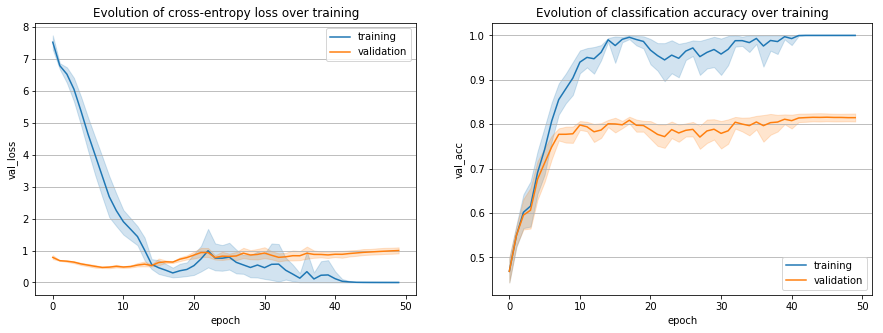

In [95]:
m = CN8
h, t = cv_k_loads(m, epochs=50, cv=10)
plot_hist(h)

Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.000812,1.0,1.136451,0.8126,49
best,0.001064,1.0,1.107765,0.8126,45


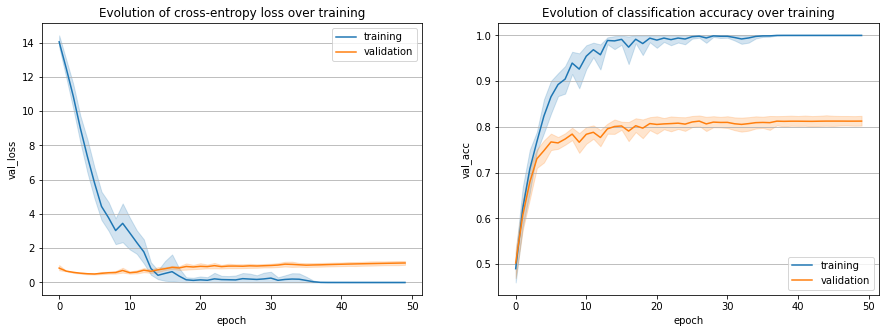

In [100]:
m = CN8
h, t = cv_k_loads(m, epochs=50, cv=10, mini_batch_size=50)
plot_hist(h)

Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.063132,1.0000,0.610132,0.8099,49
best,0.069737,0.9998,0.605234,0.8107,48


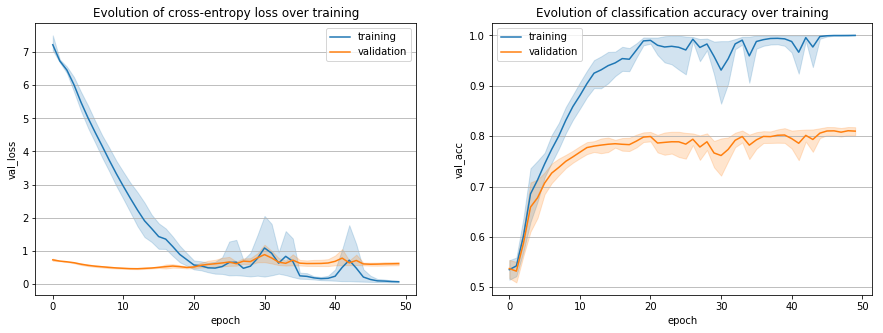

In [103]:
m = CN8
h, t = cv_k_loads(m, epochs=50, cv=10, opt=torch.optim.Adamax)
plot_hist(h)

Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.952884,0.9697,0.528250,0.7887,49
best,1.942571,0.9568,0.457173,0.7942,37


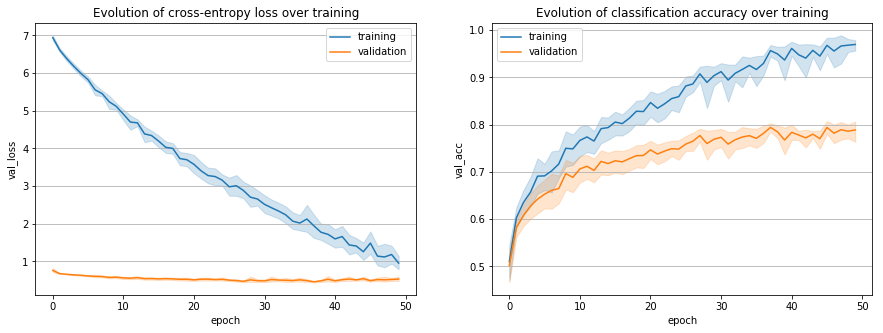

In [107]:
m = CN8
h, t = cv_k_loads(m, epochs=50, cv=10, opt=torch.optim.Adadelta, eta=0.05)
plot_hist(h)

In [109]:
class CN9(nn.Module):
    def __init__(self, nb_hidden=128):
        super(CN9, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4) 
        self.fc1 = nn.Linear(64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.selu(x)
        x = self.conv2(x)
        x = F.selu(x)
        x = self.conv3(x)
        x = F.selu(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = F.selu(x)
        x = self.conv5(x)
        x = F.selu(x)
        x = self.pool2(x)
        x = F.selu(x)
        x = self.fc1(x.view(-1, 64))
        x = F.selu(x)
        x = self.fc2(x)
        return x
    
CN_9 = CN9()
print(count_parameters(CN_9))

69426


Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,0.005191,1.0,0.743443,0.8108,49
best,0.006250,1.0,0.732760,0.8111,46


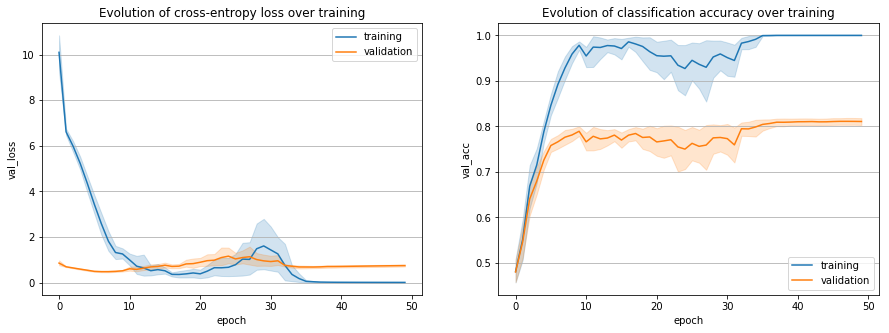

In [111]:
m = CN9
h, t = cv_k_loads(m, epochs=50, cv=10)
plot_hist(h)